# Using 🍬 SuiteEval

# Setup

Set up a new environment if you're working locally! Otherwise you can just run all cells

In [ ]:
%pip install git+https://github.com/Parry-Parry/suiteeval.git pyterrier-pisa seaborn

In [8]:
from os.path import join
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyterrier_pisa import PisaIndex
from adjustText import adjust_text

from suiteeval import DatasetContext, NanoBEIR

### Visualisation

In [9]:
def plot_optimal(results: pd.DataFrame):
    idx = results.groupby("dataset")["nDCG@10"].idxmax()
    best = results.loc[idx, ["dataset", "k1", "b", "nDCG@10"]].reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(best["k1"], best["b"], c=best["nDCG@10"], s=70)

    # --- Replace your annotation loop with this block ---
    texts = []
    for _, row in best.iterrows():
        txt = ax.text(
            row["k1"], row["b"], f"{row['dataset']} ({row['nDCG@10']:.3f})", fontsize=9
        )
        texts.append(txt)

    # Give labels room to move and repel them from each other and the points
    plt.margins(x=0.05, y=0.05)
    adjust_text(
        texts,
        x=best["k1"].to_numpy(),
        y=best["b"].to_numpy(),
        ax=ax,
        force_points=0.5,  # repel from points
        force_text=0.5,  # repel text from text
        expand_points=(1.1, 1.2),
        expand_text=(1.05, 1.2),
        lim=200,  # iteration budget
        only_move={"points": "xy", "text": "xy"},  # allow 2D movement
        arrowprops=dict(arrowstyle="-", lw=0.5, alpha=0.6),  # thin leader lines
    )
    # --- end replacement ---

    ax.set_xlabel("k1")
    ax.set_ylabel("b")
    ax.set_title("Best (k1, b) per dataset by nDCG@10")
    cbar = fig.colorbar(sc, ax=ax, label="nDCG@10")  # noqa: F841
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [29]:
def plot_metric_vs_b(
    results: pd.DataFrame,
    datasets: list[str] | None = None,
    metric: str = "nDCG@10",
    agg: str = "mean",  # one of {"mean","median","max"}
    error: str = "std",  # one of {"std","minmax","none"}
    figsize: tuple[int, int] = (9, 6),
    linewidth: float = 2.0,
    alpha_band: float = 0.20,
):
    """
    Line plot of metric vs b, one line per dataset. Each point aggregates over k1.

    Parameters
    ----------
    results : DataFrame
        Must contain columns: ["dataset", "b", metric] and multiple k1 settings per (dataset, b).
    datasets : list[str] | None
        If provided, restrict the plot to these datasets.
    metric : str
        Column name to plot on the y-axis (e.g., "nDCG@10").
    agg : {"mean","median","max"}
        Aggregation over k1 for each (dataset, b).
    error : {"std","minmax","none"}
        Variance band across k1 for each (dataset, b):
          - "std": mean/median ± 1 std
          - "minmax": fill between min and max
          - "none": no band
    """
    required = {"dataset", "b", metric}
    missing = required - set(results.columns)
    if missing:
        raise ValueError(f"results is missing required columns: {sorted(missing)}")

    df = results.copy()

    # Optional dataset filter
    if datasets is not None:
        df = df[df["dataset"].isin(datasets)]

    # Ensure numeric b and metric
    df = df.copy()
    df["b"] = pd.to_numeric(df["b"], errors="coerce")
    df[metric] = pd.to_numeric(df[metric], errors="coerce")
    df = df.dropna(subset=["dataset", "b", metric])

    if df.empty:
        raise ValueError("No data to plot after filtering/casting.")

    # Aggregate over k1 by (dataset, b)
    agg_map = {
        "mean": np.mean,
        "median": np.median,
        "max": np.max,
    }
    if agg not in agg_map:
        raise ValueError('agg must be one of {"mean","median","max"}')

    grouped = df.groupby(["dataset", "b"])[metric]
    summary = grouped.agg(
        mean="mean",
        median="median",
        std="std",
        min="min",
        max="max",
        count="count",
    ).reset_index()

    # Select central tendency to plot
    if agg == "mean":
        summary["y"] = summary["mean"]
    elif agg == "median":
        summary["y"] = summary["median"]
    else:  # "max"
        summary["y"] = summary["max"]

    # Prepare plot
    fig, ax = plt.subplots(figsize=figsize)

    for dataset, sub in summary.groupby("dataset", sort=False):
        sub = sub.sort_values("b")

        # Central line
        ax.plot(
            sub["b"].to_numpy(),
            sub["y"].to_numpy(),
            label=dataset,
            linewidth=linewidth,
        )

        # Variance band
        if error == "std":
            # std may be NaN when count==1; replace NaN with 0
            std = sub["std"].fillna(0.0).to_numpy()
            y = sub["y"].to_numpy()
            ax.fill_between(sub["b"].to_numpy(), y - std, y + std, alpha=alpha_band)
        elif error == "minmax":
            ymin = sub["min"].to_numpy()
            ymax = sub["max"].to_numpy()
            ax.fill_between(sub["b"].to_numpy(), ymin, ymax, alpha=alpha_band)
        # "none": no band

    ax.set_xlabel("b")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} vs b (aggregated over k1)")
    ax.grid(True, alpha=0.3)
    ax.legend(
        title="Dataset",
        loc="center left",  # anchor the legend's left-center
        bbox_to_anchor=(
            1.02,
            0.5,
        ),  # place just outside the right edge, vertically centered
        frameon=False,
        ncol=1,
    )
    fig.subplots_adjust(right=0.80)
    plt.tight_layout()
    plt.show()

## A Simple Experiment

Let's do a sweep on NanoBEIR to see how different BM25 parameters perform under different domains and query geometries.

We will use PyTerrier-PISA to quickly index and execute many queries

### Setting up our Pipelines

🍬 SuiteEval requires one or more generator functions to create new indices and pipelines dynamically, our pipeline generator will index a corpus and then yeild a bm25 model for our parameter space.
 
We are going to explore values of k1 and b. 

In [30]:
K1_VALUES = np.arange(0.1, 3.0, 0.5)
B_VALUES = np.arange(0.25, 1.0, 0.25)


def bm25_sweep(context: DatasetContext):
    index = PisaIndex(
        join(context.path, "index.pisa")
    )  # context.path is a temporary directory
    index.index(
        context.get_corpus_iter()
    )  # get_corpus_iter gives us a pyterrier compatible generator of {docno, text} records

    for K_1 in K1_VALUES:
        for B in B_VALUES:
            yield (
                index.bm25(k1=K_1, b=B),
                "BM25(k1={:.1f}, b={:.1f})".format(K_1, B),
            )  # When we yield a model and a name, this name is passed to PyTerrier

Now we can execute our pipeline. Under the hood we are creating indexes and models dynamically and running benchmarks across all datasets.

In [12]:
results = NanoBEIR(bm25_sweep)

nano-beir/arguana documents:   0%|          | 0/3635 [00:00<?, ?it/s]/opt/miniconda3/envs/suiteeval-demo/lib/python3.11/site-packages/pyterrier_pisa/__init__.py:205: UserWarning: text_field not specified; indexing all str fields: ['text']
  warn(f'text_field not specified; indexing all str fields: {text_field}')
nano-beir/arguana documents: 100%|██████████| 3635/3635 [00:00<00:00, 106297.81it/s]


[2025-10-21 13:33:23.089] [info] [Batch 0] Processed documents [0, 3635)
[2025-10-21 13:33:23.093] [info] Merging titles
[2025-10-21 13:33:23.093] [info] Creating document lexicon
[2025-10-21 13:33:23.094] [info] Merging URLs
[2025-10-21 13:33:23.094] [info] Collecting terms
[2025-10-21 13:33:23.100] [info] Writing terms
[2025-10-21 13:33:23.103] [info] Mapping terms
[2025-10-21 13:33:23.105] [info] Remapping IDs
[2025-10-21 13:33:23.192] [info] Concatenating batches
[2025-10-21 13:33:23.195] [info] Success.
[2025-10-21 13:33:23.196] [info] Inverting [0, 3635)
[2025-10-21 13:33:23.290] [info] Number of terms: 15201
[2025-10-21 13:33:23.290] [info] Number of documents: 3635
[2025-10-21 13:33:23.290] [info] Number of postings: 365179
[2025-10-21 13:33:23.293] [info] Dropping 0 terms
[2025-10-21 13:33:23.293] [info] Reading sizes...
[2025-10-21 13:33:23.293] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:23.316] [info] number of elements / number of blocks

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:23.716] [info] Dropping 0 terms
[2025-10-21 13:33:23.716] [info] Reading sizes...
[2025-10-21 13:33:23.716] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:23.728] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:23.728] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-0.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:23.745] [info] Index compressed in 0.016316 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:24.116] [info] Dropping 0 terms
[2025-10-21 13:33:24.117] [info] Reading sizes...
[2025-10-21 13:33:24.117] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:24.129] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:24.129] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-0.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:24.146] [info] Index compressed in 0.01636 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:24.525] [info] Dropping 0 terms
[2025-10-21 13:33:24.525] [info] Reading sizes...
[2025-10-21 13:33:24.525] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:24.537] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:24.537] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-0.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:24.553] [info] Index compressed in 0.015974 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:24.937] [info] Dropping 0 terms
[2025-10-21 13:33:24.937] [info] Reading sizes...
[2025-10-21 13:33:24.937] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:24.949] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:24.950] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-0.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:24.967] [info] Index compressed in 0.017545 seconds
[2025-10-21 13:33:25.340] [info] Dropping 0 terms
[2025-10-21 13:33:25.341] [info] Reading sizes...
[2025-10-21 13:33:25.341] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:25.352] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:25.353] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-0.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:25.369] [info] Index compressed in 0.016168 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:25.746] [info] Dropping 0 terms
[2025-10-21 13:33:25.746] [info] Reading sizes...
[2025-10-21 13:33:25.746] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:25.758] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:25.758] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-1.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:25.774] [info] Index compressed in 0.015621 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:26.148] [info] Dropping 0 terms
[2025-10-21 13:33:26.148] [info] Reading sizes...
[2025-10-21 13:33:26.148] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:26.160] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:26.160] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-1.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:26.177] [info] Index compressed in 0.016505 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:26.571] [info] Dropping 0 terms
[2025-10-21 13:33:26.571] [info] Reading sizes...
[2025-10-21 13:33:26.571] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:26.582] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:26.582] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-1.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:26.599] [info] Index compressed in 0.016456 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:26.993] [info] Dropping 0 terms
[2025-10-21 13:33:26.993] [info] Reading sizes...
[2025-10-21 13:33:26.993] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:27.006] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:27.007] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-1.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:27.023] [info] Index compressed in 0.01623 seconds
[2025-10-21 13:33:27.401] [info] Dropping 0 terms
[2025-10-21 13:33:27.401] [info] Reading sizes...
[2025-10-21 13:33:27.401] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:27.413] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:27.413] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-1.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:27.429] [info] Index compressed in 0.01603 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:27.817] [info] Dropping 0 terms
[2025-10-21 13:33:27.817] [info] Reading sizes...
[2025-10-21 13:33:27.817] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:27.830] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:27.830] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-1.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:27.850] [info] Index compressed in 0.019883 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:28.222] [info] Dropping 0 terms
[2025-10-21 13:33:28.222] [info] Reading sizes...
[2025-10-21 13:33:28.222] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:28.233] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:28.234] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-2.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:28.250] [info] Index compressed in 0.015899 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:28.630] [info] Dropping 0 terms
[2025-10-21 13:33:28.630] [info] Reading sizes...
[2025-10-21 13:33:28.630] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:28.642] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:28.642] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-2.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:28.658] [info] Index compressed in 0.016099 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:29.031] [info] Dropping 0 terms
[2025-10-21 13:33:29.031] [info] Reading sizes...
[2025-10-21 13:33:29.031] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:29.042] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:29.043] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-2.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:29.059] [info] Index compressed in 0.01599 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:29.444] [info] Dropping 0 terms
[2025-10-21 13:33:29.445] [info] Reading sizes...
[2025-10-21 13:33:29.445] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:29.456] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:29.456] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-2.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:29.472] [info] Index compressed in 0.015918 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:29.843] [info] Dropping 0 terms
[2025-10-21 13:33:29.843] [info] Reading sizes...
[2025-10-21 13:33:29.843] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:29.854] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:29.855] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-2.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:29.871] [info] Index compressed in 0.015931 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:30.239] [info] Dropping 0 terms
[2025-10-21 13:33:30.239] [info] Reading sizes...
[2025-10-21 13:33:30.239] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:30.251] [info] number of elements / number of blocks: 19.0784
[2025-10-21 13:33:30.251] [info] Processing 3635 documents (streaming)
/tmp/tmps_x7wvqi-nano-beir-arguana/index.pisa/bm25.k1-2.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:30.267] [info] Index compressed in 0.016202 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
nano-beir/climate-fever documents:   0%|          | 0/3408 [00:00<?, ?it/s]/opt/miniconda3/envs/suiteeval-demo/lib/python3.11/site-packages/pyterrier_pisa/__init__.py:205: UserWarning: text_field not specified; indexing all str fields: ['text']
  warn(f'text_field not specified; indexing all str fields: {text_field}')
nano-beir/climate-fever documents: 100%|██████████| 3408/3408 [00:00<00:00, 91564.85it/s]


[2025-10-21 13:33:31.860] [info] [Batch 0] Processed documents [0, 3408)
[2025-10-21 13:33:31.865] [info] Merging titles
[2025-10-21 13:33:31.865] [info] Creating document lexicon
[2025-10-21 13:33:31.866] [info] Merging URLs
[2025-10-21 13:33:31.866] [info] Collecting terms
[2025-10-21 13:33:31.877] [info] Writing terms
[2025-10-21 13:33:31.882] [info] Mapping terms
[2025-10-21 13:33:31.887] [info] Remapping IDs
[2025-10-21 13:33:31.997] [info] Concatenating batches
[2025-10-21 13:33:32.003] [info] Success.
[2025-10-21 13:33:32.004] [info] Inverting [0, 3408)
[2025-10-21 13:33:32.153] [info] Number of terms: 24885
[2025-10-21 13:33:32.153] [info] Number of documents: 3408
[2025-10-21 13:33:32.153] [info] Number of postings: 447815
[2025-10-21 13:33:32.156] [info] Dropping 0 terms
[2025-10-21 13:33:32.156] [info] Reading sizes...
[2025-10-21 13:33:32.156] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:32.174] [info] number of elements / number of blocks

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:32.421] [info] Dropping 0 terms
[2025-10-21 13:33:32.421] [info] Reading sizes...
[2025-10-21 13:33:32.421] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:32.439] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:32.439] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-0.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:32.463] [info] Index compressed in 0.023837 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:32.685] [info] Dropping 0 terms
[2025-10-21 13:33:32.685] [info] Reading sizes...
[2025-10-21 13:33:32.685] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:32.702] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:32.703] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-0.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:32.727] [info] Index compressed in 0.024226 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:32.956] [info] Dropping 0 terms
[2025-10-21 13:33:32.956] [info] Reading sizes...
[2025-10-21 13:33:32.957] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:32.974] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:32.974] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-0.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:33.002] [info] Index compressed in 0.02817 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:33.257] [info] Dropping 0 terms
[2025-10-21 13:33:33.257] [info] Reading sizes...
[2025-10-21 13:33:33.257] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:33.275] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:33.275] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-0.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:33.300] [info] Index compressed in 0.0249 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:33.521] [info] Dropping 0 terms
[2025-10-21 13:33:33.521] [info] Reading sizes...
[2025-10-21 13:33:33.521] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:33.539] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:33.539] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-0.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:33.566] [info] Index compressed in 0.026464 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:33.795] [info] Dropping 0 terms
[2025-10-21 13:33:33.795] [info] Reading sizes...
[2025-10-21 13:33:33.795] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:33.812] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:33.812] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-1.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:33.835] [info] Index compressed in 0.023034 seconds
[2025-10-21 13:33:34.055] [info] Dropping 0 terms
[2025-10-21 13:33:34.055] [info] Reading sizes...
[2025-10-21 13:33:34.055] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:34.070] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:34.071] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-1.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:34.095] [info] Index compressed in 0.02392 seco

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:34.323] [info] Dropping 0 terms
[2025-10-21 13:33:34.323] [info] Reading sizes...
[2025-10-21 13:33:34.323] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:34.340] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:34.340] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-1.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:34.364] [info] Index compressed in 0.023738 seconds
[2025-10-21 13:33:34.587] [info] Dropping 0 terms
[2025-10-21 13:33:34.587] [info] Reading sizes...
[2025-10-21 13:33:34.587] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:34.604] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:34.605] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-1.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:34.628] [info] Index compressed in 0.023454 se

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:34.849] [info] Dropping 0 terms
[2025-10-21 13:33:34.849] [info] Reading sizes...
[2025-10-21 13:33:34.849] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:34.865] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:34.865] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-1.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:34.889] [info] Index compressed in 0.023165 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:35.113] [info] Dropping 0 terms
[2025-10-21 13:33:35.113] [info] Reading sizes...
[2025-10-21 13:33:35.113] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:35.131] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:35.131] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-1.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:35.155] [info] Index compressed in 0.024019 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:35.378] [info] Dropping 0 terms
[2025-10-21 13:33:35.378] [info] Reading sizes...
[2025-10-21 13:33:35.378] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:35.394] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:35.395] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-2.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:35.418] [info] Index compressed in 0.023033 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:35.637] [info] Dropping 0 terms
[2025-10-21 13:33:35.637] [info] Reading sizes...
[2025-10-21 13:33:35.637] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:35.653] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:35.653] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-2.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:35.680] [info] Index compressed in 0.026116 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:35.904] [info] Dropping 0 terms
[2025-10-21 13:33:35.904] [info] Reading sizes...
[2025-10-21 13:33:35.904] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:35.922] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:35.922] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-2.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:35.945] [info] Index compressed in 0.022897 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:36.164] [info] Dropping 0 terms
[2025-10-21 13:33:36.165] [info] Reading sizes...
[2025-10-21 13:33:36.165] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:36.181] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:36.181] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-2.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:36.204] [info] Index compressed in 0.023175 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:36.423] [info] Dropping 0 terms
[2025-10-21 13:33:36.423] [info] Reading sizes...
[2025-10-21 13:33:36.423] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:36.440] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:36.441] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-2.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:36.465] [info] Index compressed in 0.024722 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:36.688] [info] Dropping 0 terms
[2025-10-21 13:33:36.688] [info] Reading sizes...
[2025-10-21 13:33:36.688] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:36.705] [info] number of elements / number of blocks: 15.2271
[2025-10-21 13:33:36.706] [info] Processing 3408 documents (streaming)
/tmp/tmp4l756hxv-nano-beir-climate-fever/index.pisa/bm25.k1-2.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:36.729] [info] Index compressed in 0.02383 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
nano-beir/dbpedia-entity documents:   0%|          | 0/6045 [00:00<?, ?it/s]/opt/miniconda3/envs/suiteeval-demo/lib/python3.11/site-packages/pyterrier_pisa/__init__.py:205: UserWarning: text_field not specified; indexing all str fields: ['text']
  warn(f'text_field not specified; indexing all str fields: {text_field}')
nano-beir/dbpedia-entity documents: 100%|██████████| 6045/6045 [00:00<00:00, 163576.80it/s]


[2025-10-21 13:33:37.463] [info] [Batch 0] Processed documents [0, 6045)
[2025-10-21 13:33:37.468] [info] Merging titles
[2025-10-21 13:33:37.468] [info] Creating document lexicon
[2025-10-21 13:33:37.470] [info] Merging URLs
[2025-10-21 13:33:37.470] [info] Collecting terms
[2025-10-21 13:33:37.479] [info] Writing terms
[2025-10-21 13:33:37.483] [info] Mapping terms
[2025-10-21 13:33:37.487] [info] Remapping IDs
[2025-10-21 13:33:37.894] [info] Concatenating batches
[2025-10-21 13:33:37.897] [info] Success.
[2025-10-21 13:33:37.898] [info] Inverting [0, 6045)
[2025-10-21 13:33:37.967] [info] Number of terms: 24233
[2025-10-21 13:33:37.967] [info] Number of documents: 6045
[2025-10-21 13:33:37.967] [info] Number of postings: 250576
[2025-10-21 13:33:37.970] [info] Dropping 0 terms
[2025-10-21 13:33:37.970] [info] Reading sizes...
[2025-10-21 13:33:37.970] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:37.983] [info] number of elements / number of blocks

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:38.170] [info] Dropping 0 terms
[2025-10-21 13:33:38.170] [info] Reading sizes...
[2025-10-21 13:33:38.170] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:38.183] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:38.183] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-0.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:38.201] [info] Index compressed in 0.017404 seconds
[2025-10-21 13:33:38.353] [info] Dropping 0 terms
[2025-10-21 13:33:38.353] [info] Reading sizes...
[2025-10-21 13:33:38.353] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:38.366] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:38.366] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-0.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:38.384] [info] Index compressed in 0.018319 s

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:38.534] [info] Dropping 0 terms
[2025-10-21 13:33:38.534] [info] Reading sizes...
[2025-10-21 13:33:38.534] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:38.547] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:38.547] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-0.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:38.567] [info] Index compressed in 0.019582 seconds
[2025-10-21 13:33:38.726] [info] Dropping 0 terms
[2025-10-21 13:33:38.726] [info] Reading sizes...
[2025-10-21 13:33:38.726] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:38.738] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:38.739] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-0.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:38.758] [info] Index compressed in 0.019179 s

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:38.909] [info] Dropping 0 terms
[2025-10-21 13:33:38.909] [info] Reading sizes...
[2025-10-21 13:33:38.909] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:38.922] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:38.922] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-0.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:38.940] [info] Index compressed in 0.017573 seconds
[2025-10-21 13:33:39.094] [info] Dropping 0 terms
[2025-10-21 13:33:39.094] [info] Reading sizes...
[2025-10-21 13:33:39.094] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:39.106] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:39.107] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-1.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:39.125] [info] Index compressed in 0.018422 

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:39.277] [info] Dropping 0 terms
[2025-10-21 13:33:39.277] [info] Reading sizes...
[2025-10-21 13:33:39.277] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:39.289] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:39.290] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-1.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:39.308] [info] Index compressed in 0.018594 seconds
[2025-10-21 13:33:39.460] [info] Dropping 0 terms
[2025-10-21 13:33:39.461] [info] Reading sizes...
[2025-10-21 13:33:39.461] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:39.474] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:39.474] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-1.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:39.493] [info] Index compressed in 0.018546 s

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:39.647] [info] Dropping 0 terms
[2025-10-21 13:33:39.647] [info] Reading sizes...
[2025-10-21 13:33:39.647] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:39.660] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:39.661] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-1.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:39.679] [info] Index compressed in 0.018443 seconds
[2025-10-21 13:33:39.835] [info] Dropping 0 terms
[2025-10-21 13:33:39.835] [info] Reading sizes...
[2025-10-21 13:33:39.835] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:39.848] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:39.848] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-1.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:39.866] [info] Index compressed in 0.017628 s

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:40.018] [info] Dropping 0 terms
[2025-10-21 13:33:40.018] [info] Reading sizes...
[2025-10-21 13:33:40.018] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:40.030] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:40.030] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-1.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:40.048] [info] Index compressed in 0.017952 seconds
[2025-10-21 13:33:40.202] [info] Dropping 0 terms
[2025-10-21 13:33:40.202] [info] Reading sizes...
[2025-10-21 13:33:40.202] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:40.215] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:40.215] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-2.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:40.233] [info] Index compressed in 0.017949 

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:40.389] [info] Dropping 0 terms
[2025-10-21 13:33:40.389] [info] Reading sizes...
[2025-10-21 13:33:40.389] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:40.403] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:40.403] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-2.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:40.421] [info] Index compressed in 0.018067 seconds
[2025-10-21 13:33:40.578] [info] Dropping 0 terms
[2025-10-21 13:33:40.578] [info] Reading sizes...
[2025-10-21 13:33:40.578] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:40.590] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:40.591] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-2.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:40.608] [info] Index compressed in 0.017801 s

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:40.770] [info] Dropping 0 terms
[2025-10-21 13:33:40.770] [info] Reading sizes...
[2025-10-21 13:33:40.770] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:40.782] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:40.782] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-2.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:40.800] [info] Index compressed in 0.017456 seconds
[2025-10-21 13:33:40.956] [info] Dropping 0 terms
[2025-10-21 13:33:40.956] [info] Reading sizes...
[2025-10-21 13:33:40.956] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:40.968] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:40.968] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-2.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:40.986] [info] Index compressed in 0.017714 s

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:41.139] [info] Dropping 0 terms
[2025-10-21 13:33:41.139] [info] Reading sizes...
[2025-10-21 13:33:41.139] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:41.151] [info] number of elements / number of blocks: 9.51205
[2025-10-21 13:33:41.152] [info] Processing 6045 documents (streaming)
/tmp/tmpit8klko0-nano-beir-dbpedia-entity/index.pisa/bm25.k1-2.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:41.169] [info] Index compressed in 0.017611 seconds


nano-beir/fever documents:   0%|          | 0/4996 [00:00<?, ?it/s]/opt/miniconda3/envs/suiteeval-demo/lib/python3.11/site-packages/pyterrier_pisa/__init__.py:205: UserWarning: text_field not specified; indexing all str fields: ['text']
  warn(f'text_field not specified; indexing all str fields: {text_field}')
nano-beir/fever documents: 100%|██████████| 4996/4996 [00:00<00:00, 120442.71it/s]


[2025-10-21 13:33:42.682] [info] [Batch 0] Processed documents [0, 4996)
[2025-10-21 13:33:42.689] [info] Merging titles
[2025-10-21 13:33:42.690] [info] Creating document lexicon
[2025-10-21 13:33:42.691] [info] Merging URLs
[2025-10-21 13:33:42.691] [info] Collecting terms
[2025-10-21 13:33:42.706] [info] Writing terms
[2025-10-21 13:33:42.713] [info] Mapping terms
[2025-10-21 13:33:42.719] [info] Remapping IDs
[2025-10-21 13:33:42.834] [info] Concatenating batches
[2025-10-21 13:33:42.841] [info] Success.
[2025-10-21 13:33:42.842] [info] Inverting [0, 4996)
[2025-10-21 13:33:42.999] [info] Number of terms: 37672
[2025-10-21 13:33:42.999] [info] Number of documents: 4996
[2025-10-21 13:33:42.999] [info] Number of postings: 555934
[2025-10-21 13:33:43.002] [info] Dropping 0 terms
[2025-10-21 13:33:43.002] [info] Reading sizes...
[2025-10-21 13:33:43.002] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:43.024] [info] number of elements / number of blocks

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:43.239] [info] Dropping 0 terms
[2025-10-21 13:33:43.239] [info] Reading sizes...
[2025-10-21 13:33:43.239] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:43.262] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:43.262] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-0.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:43.298] [info] Index compressed in 0.035512 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 1% [0s]

[2025-10-21 13:33:43.488] [info] Dropping 0 terms
[2025-10-21 13:33:43.489] [info] Reading sizes...
[2025-10-21 13:33:43.489] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:43.511] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:43.512] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-0.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:43.544] [info] Index compressed in 0.032298 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 1% [0s]

[2025-10-21 13:33:43.735] [info] Dropping 0 terms
[2025-10-21 13:33:43.735] [info] Reading sizes...
[2025-10-21 13:33:43.735] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:43.758] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:43.759] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-0.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:43.792] [info] Index compressed in 0.033296 seconds
[2025-10-21 13:33:43.983] [info] Dropping 0 terms
[2025-10-21 13:33:43.983] [info] Reading sizes...
[2025-10-21 13:33:43.983] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:44.006] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:44.007] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-0.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:44.039] [info] Index compressed in 0.032024 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:44.247] [info] Dropping 0 terms
[2025-10-21 13:33:44.248] [info] Reading sizes...
[2025-10-21 13:33:44.248] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:44.271] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:44.273] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-0.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:44.306] [info] Index compressed in 0.033854 seconds
[2025-10-21 13:33:44.497] [info] Dropping 0 terms
[2025-10-21 13:33:44.497] [info] Reading sizes...
[2025-10-21 13:33:44.497] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:44.519] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:44.520] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-1.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:44.552] [info] Index compressed in 0.032027 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:44.740] [info] Dropping 0 terms
[2025-10-21 13:33:44.740] [info] Reading sizes...
[2025-10-21 13:33:44.740] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:44.762] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:44.763] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-1.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:44.796] [info] Index compressed in 0.03336 seconds
[2025-10-21 13:33:44.985] [info] Dropping 0 terms


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 1% [0s]

[2025-10-21 13:33:44.985] [info] Reading sizes...
[2025-10-21 13:33:44.985] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:45.007] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:45.007] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-1.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:45.039] [info] Index compressed in 0.031527 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:45.245] [info] Dropping 0 terms
[2025-10-21 13:33:45.245] [info] Reading sizes...
[2025-10-21 13:33:45.245] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:45.270] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:45.271] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-1.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:45.307] [info] Index compressed in 0.036063 seconds
[2025-10-21 13:33:45.511] [info] Dropping 0 terms
[2025-10-21 13:33:45.512] [info] Reading sizes...
[2025-10-21 13:33:45.512] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:45.534] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:45.535] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-1.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:45.566] [info] Index compressed in 0.031216 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:45.761] [info] Dropping 0 terms
[2025-10-21 13:33:45.761] [info] Reading sizes...
[2025-10-21 13:33:45.761] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:45.784] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:45.784] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-1.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:45.815] [info] Index compressed in 0.030831 seconds
[2025-10-21 13:33:46.007] [info] Dropping 0 terms
[2025-10-21 13:33:46.007] [info] Reading sizes...
[2025-10-21 13:33:46.007] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:46.030] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:46.031] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-2.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:46.062] [info] Index compressed in 0.031162 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 58% [0s]

[2025-10-21 13:33:46.251] [info] Dropping 0 terms
[2025-10-21 13:33:46.251] [info] Reading sizes...
[2025-10-21 13:33:46.251] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:46.274] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:46.275] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-2.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:46.307] [info] Index compressed in 0.031614 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:46.496] [info] Dropping 0 terms
[2025-10-21 13:33:46.496] [info] Reading sizes...
[2025-10-21 13:33:46.496] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:46.520] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:46.521] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-2.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:46.553] [info] Index compressed in 0.032512 seconds
[2025-10-21 13:33:46.747] [info] Dropping 0 terms
[2025-10-21 13:33:46.747] [info] Reading sizes...
[2025-10-21 13:33:46.747] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:46.771] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:46.771] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-2.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:46.810] [info] Index compressed in 0.039219 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 37% [0s]

[2025-10-21 13:33:47.005] [info] Dropping 0 terms
[2025-10-21 13:33:47.005] [info] Reading sizes...
[2025-10-21 13:33:47.005] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:47.027] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:47.027] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-2.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:47.060] [info] Index compressed in 0.032898 seconds


Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:47.254] [info] Dropping 0 terms
[2025-10-21 13:33:47.254] [info] Reading sizes...
[2025-10-21 13:33:47.254] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:47.278] [info] number of elements / number of blocks: 12.8861
[2025-10-21 13:33:47.278] [info] Processing 4996 documents (streaming)
/tmp/tmpp43kv2es-nano-beir-fever/index.pisa/bm25.k1-2.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:47.311] [info] Index compressed in 0.032673 seconds


nano-beir/fiqa documents:   0%|          | 0/4598 [00:00<?, ?it/s]/opt/miniconda3/envs/suiteeval-demo/lib/python3.11/site-packages/pyterrier_pisa/__init__.py:205: UserWarning: text_field not specified; indexing all str fields: ['text']
  warn(f'text_field not specified; indexing all str fields: {text_field}')
nano-beir/fiqa documents: 100%|██████████| 4598/4598 [00:00<00:00, 139113.26it/s]


[2025-10-21 13:33:48.463] [info] [Batch 0] Processed documents [0, 4598)
[2025-10-21 13:33:48.466] [info] Merging titles
[2025-10-21 13:33:48.467] [info] Creating document lexicon
[2025-10-21 13:33:48.468] [info] Merging URLs
[2025-10-21 13:33:48.468] [info] Collecting terms
[2025-10-21 13:33:48.472] [info] Writing terms
[2025-10-21 13:33:48.474] [info] Mapping terms
[2025-10-21 13:33:48.476] [info] Remapping IDs
[2025-10-21 13:33:48.577] [info] Concatenating batches
[2025-10-21 13:33:48.582] [info] Success.
[2025-10-21 13:33:48.583] [info] Inverting [0, 4598)
[2025-10-21 13:33:48.691] [info] Number of terms: 11405
[2025-10-21 13:33:48.691] [info] Number of documents: 4598
[2025-10-21 13:33:48.691] [info] Number of postings: 397607
[2025-10-21 13:33:48.694] [info] Dropping 0 terms
[2025-10-21 13:33:48.694] [info] Reading sizes...
[2025-10-21 13:33:48.694] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:48.705] [info] number of elements / number of blocks

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:48.927] [info] Dropping 0 terms
[2025-10-21 13:33:48.927] [info] Reading sizes...
[2025-10-21 13:33:48.927] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:48.939] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:48.939] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-0.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:48.953] [info] Index compressed in 0.014206 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:49.162] [info] Dropping 0 terms
[2025-10-21 13:33:49.162] [info] Reading sizes...
[2025-10-21 13:33:49.162] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:49.173] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:49.174] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-0.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:49.187] [info] Index compressed in 0.013306 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:49.394] [info] Dropping 0 terms
[2025-10-21 13:33:49.394] [info] Reading sizes...
[2025-10-21 13:33:49.394] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:49.405] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:49.406] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-0.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:49.419] [info] Index compressed in 0.013711 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:49.625] [info] Dropping 0 terms
[2025-10-21 13:33:49.625] [info] Reading sizes...
[2025-10-21 13:33:49.625] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:49.636] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:49.636] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-0.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:49.650] [info] Index compressed in 0.013393 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:49.855] [info] Dropping 0 terms
[2025-10-21 13:33:49.855] [info] Reading sizes...
[2025-10-21 13:33:49.855] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:49.866] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:49.866] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-0.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:49.880] [info] Index compressed in 0.013675 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:50.088] [info] Dropping 0 terms
[2025-10-21 13:33:50.088] [info] Reading sizes...
[2025-10-21 13:33:50.088] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:50.100] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:50.100] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-1.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:50.114] [info] Index compressed in 0.013378 seconds
[2025-10-21 13:33:50.319] [info] Dropping 0 terms
[2025-10-21 13:33:50.319] [info] Reading sizes...
[2025-10-21 13:33:50.319] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:50.330] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:50.331] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-1.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:50.344] [info] Index compressed in 0.013395 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:50.552] [info] Dropping 0 terms
[2025-10-21 13:33:50.553] [info] Reading sizes...
[2025-10-21 13:33:50.553] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:50.564] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:50.564] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-1.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:50.578] [info] Index compressed in 0.013874 seconds
[2025-10-21 13:33:50.788] [info] Dropping 0 terms
[2025-10-21 13:33:50.788] [info] Reading sizes...
[2025-10-21 13:33:50.788] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:50.799] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:50.799] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-1.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:50.812] [info] Index compressed in 0.013339 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:51.016] [info] Dropping 0 terms
[2025-10-21 13:33:51.016] [info] Reading sizes...
[2025-10-21 13:33:51.016] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:51.028] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:51.028] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-1.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:51.041] [info] Index compressed in 0.013346 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:51.247] [info] Dropping 0 terms
[2025-10-21 13:33:51.247] [info] Reading sizes...
[2025-10-21 13:33:51.247] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:51.258] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:51.258] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-1.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:51.272] [info] Index compressed in 0.013688 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:51.476] [info] Dropping 0 terms
[2025-10-21 13:33:51.476] [info] Reading sizes...
[2025-10-21 13:33:51.476] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:51.488] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:51.488] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-2.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:51.503] [info] Index compressed in 0.014254 seconds
[2025-10-21 13:33:51.711] [info] Dropping 0 terms
[2025-10-21 13:33:51.711] [info] Reading sizes...
[2025-10-21 13:33:51.711] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:51.723] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:51.723] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-2.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:51.737] [info] Index compressed in 0.013811 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:51.952] [info] Dropping 0 terms
[2025-10-21 13:33:51.952] [info] Reading sizes...
[2025-10-21 13:33:51.952] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:51.965] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:51.965] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-2.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:51.980] [info] Index compressed in 0.015327 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:52.191] [info] Dropping 0 terms
[2025-10-21 13:33:52.191] [info] Reading sizes...
[2025-10-21 13:33:52.191] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:52.202] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:52.203] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-2.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:52.216] [info] Index compressed in 0.013371 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:52.427] [info] Dropping 0 terms
[2025-10-21 13:33:52.427] [info] Reading sizes...
[2025-10-21 13:33:52.427] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:52.438] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:52.439] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-2.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:52.452] [info] Index compressed in 0.013701 seconds
[2025-10-21 13:33:52.655] [info] Dropping 0 terms
[2025-10-21 13:33:52.655] [info] Reading sizes...
[2025-10-21 13:33:52.655] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:52.666] [info] number of elements / number of blocks: 24.524
[2025-10-21 13:33:52.667] [info] Processing 4598 documents (streaming)
/tmp/tmpmys16wce-nano-beir-fiqa/index.pisa/bm25.k1-2.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:52.681] [info] Index compressed in 0.014275 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
nano-beir/hotpotqa documents:   0%|          | 0/5090 [00:00<?, ?it/s]/opt/miniconda3/envs/suiteeval-demo/lib/python3.11/site-packages/pyterrier_pisa/__init__.py:205: UserWarning: text_field not specified; indexing all str fields: ['text']
  warn(f'text_field not specified; indexing all str fields: {text_field}')
nano-beir/hotpotqa documents: 100%|██████████| 5090/5090 [00:00<00:00, 169130.52it/s]


[2025-10-21 13:33:53.325] [info] [Batch 0] Processed documents [0, 5090)
[2025-10-21 13:33:53.330] [info] Merging titles
[2025-10-21 13:33:53.331] [info] Creating document lexicon
[2025-10-21 13:33:53.332] [info] Merging URLs
[2025-10-21 13:33:53.332] [info] Collecting terms
[2025-10-21 13:33:53.341] [info] Writing terms
[2025-10-21 13:33:53.345] [info] Mapping terms
[2025-10-21 13:33:53.349] [info] Remapping IDs
[2025-10-21 13:33:53.438] [info] Concatenating batches
[2025-10-21 13:33:53.441] [info] Success.
[2025-10-21 13:33:53.442] [info] Inverting [0, 5090)
[2025-10-21 13:33:53.497] [info] Number of terms: 23523
[2025-10-21 13:33:53.497] [info] Number of documents: 5090
[2025-10-21 13:33:53.497] [info] Number of postings: 216348
[2025-10-21 13:33:53.500] [info] Dropping 0 terms
[2025-10-21 13:33:53.500] [info] Reading sizes...
[2025-10-21 13:33:53.500] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:53.512] [info] number of elements / number of blocks

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:53.730] [info] Dropping 0 terms
[2025-10-21 13:33:53.730] [info] Reading sizes...
[2025-10-21 13:33:53.730] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:53.742] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:53.742] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-0.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:53.759] [info] Index compressed in 0.017153 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:53.943] [info] Dropping 0 terms
[2025-10-21 13:33:53.943] [info] Reading sizes...
[2025-10-21 13:33:53.943] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:53.956] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:53.956] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-0.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:53.975] [info] Index compressed in 0.018975 seconds
[2025-10-21 13:33:54.162] [info] Dropping 0 terms
[2025-10-21 13:33:54.162] [info] Reading sizes...
[2025-10-21 13:33:54.162] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:54.174] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:54.175] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-0.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:54.192] [info] Index compressed in 0.016788 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:54.379] [info] Dropping 0 terms
[2025-10-21 13:33:54.379] [info] Reading sizes...
[2025-10-21 13:33:54.379] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:54.391] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:54.391] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-0.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:54.408] [info] Index compressed in 0.017006 seconds
[2025-10-21 13:33:54.589] [info] Dropping 0 terms
[2025-10-21 13:33:54.589] [info] Reading sizes...
[2025-10-21 13:33:54.589] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:54.601] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:54.601] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-0.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:54.618] [info] Index compressed in 0.017097 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 37% [0s]

[2025-10-21 13:33:54.803] [info] Dropping 0 terms
[2025-10-21 13:33:54.803] [info] Reading sizes...
[2025-10-21 13:33:54.803] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:54.814] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:54.815] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-1.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:54.832] [info] Index compressed in 0.01701 seconds
[2025-10-21 13:33:55.016] [info] Dropping 0 terms
[2025-10-21 13:33:55.016] [info] Reading sizes...
[2025-10-21 13:33:55.016] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:55.028] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:55.028] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-1.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:55.046] [info] Index compressed in 0.017338 seconds


Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 70% [0s]

[2025-10-21 13:33:55.225] [info] Dropping 0 terms
[2025-10-21 13:33:55.226] [info] Reading sizes...
[2025-10-21 13:33:55.226] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:55.237] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:55.238] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-1.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:55.255] [info] Index compressed in 0.016676 seconds
[2025-10-21 13:33:55.439] [info] Dropping 0 terms
[2025-10-21 13:33:55.439] [info] Reading sizes...
[2025-10-21 13:33:55.439] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:55.451] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:55.452] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-1.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:55.469] [info] Index compressed in 0.016996 seconds


Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:55.653] [info] Dropping 0 terms
[2025-10-21 13:33:55.653] [info] Reading sizes...
[2025-10-21 13:33:55.653] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:55.666] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:55.667] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-1.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:55.688] [info] Index compressed in 0.021389 seconds
[2025-10-21 13:33:55.872] [info] Dropping 0 terms
[2025-10-21 13:33:55.872] [info] Reading sizes...
[2025-10-21 13:33:55.872] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:55.885] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:55.885] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-1.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:55.902] [info] Index compressed in 0.016736 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:56.089] [info] Dropping 0 terms
[2025-10-21 13:33:56.089] [info] Reading sizes...
[2025-10-21 13:33:56.089] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:56.105] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:56.105] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-2.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:56.123] [info] Index compressed in 0.017664 seconds
[2025-10-21 13:33:56.301] [info] Dropping 0 terms
[2025-10-21 13:33:56.301] [info] Reading sizes...
[2025-10-21 13:33:56.301] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:56.313] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:56.314] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-2.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:56.330] [info] Index compressed in 0.016682 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 70% [0s]

[2025-10-21 13:33:56.516] [info] Dropping 0 terms
[2025-10-21 13:33:56.516] [info] Reading sizes...
[2025-10-21 13:33:56.516] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:56.528] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:56.529] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-2.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:56.546] [info] Index compressed in 0.017168 seconds
[2025-10-21 13:33:56.735] [info] Dropping 0 terms
[2025-10-21 13:33:56.736] [info] Reading sizes...
[2025-10-21 13:33:56.736] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:56.748] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:56.748] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-2.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:56.765] [info] Index compressed in 0.01713 seconds


Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s] statistics: 59% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:56.957] [info] Dropping 0 terms
[2025-10-21 13:33:56.957] [info] Reading sizes...
[2025-10-21 13:33:56.957] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:56.970] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:56.971] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-2.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:56.989] [info] Index compressed in 0.018266 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s] [0s]


[2025-10-21 13:33:57.179] [info] Dropping 0 terms
[2025-10-21 13:33:57.179] [info] Reading sizes...
[2025-10-21 13:33:57.179] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:57.191] [info] number of elements / number of blocks: 8.56485
[2025-10-21 13:33:57.192] [info] Processing 5090 documents (streaming)
/tmp/tmpjj7r43pr-nano-beir-hotpotqa/index.pisa/bm25.k1-2.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:57.209] [info] Index compressed in 0.017672 seconds


nano-beir/msmarco documents:   0%|          | 0/5043 [00:00<?, ?it/s]/opt/miniconda3/envs/suiteeval-demo/lib/python3.11/site-packages/pyterrier_pisa/__init__.py:205: UserWarning: text_field not specified; indexing all str fields: ['text']
  warn(f'text_field not specified; indexing all str fields: {text_field}')
nano-beir/msmarco documents: 100%|██████████| 5043/5043 [00:00<00:00, 167086.98it/s]


[2025-10-21 13:33:57.820] [info] [Batch 0] Processed documents [0, 5043)
[2025-10-21 13:33:57.825] [info] Merging titles
[2025-10-21 13:33:57.825] [info] Creating document lexicon
[2025-10-21 13:33:57.826] [info] Merging URLs
[2025-10-21 13:33:57.826] [info] Collecting terms
[2025-10-21 13:33:57.833] [info] Writing terms
[2025-10-21 13:33:57.837] [info] Mapping terms
[2025-10-21 13:33:57.841] [info] Remapping IDs
[2025-10-21 13:33:57.925] [info] Concatenating batches
[2025-10-21 13:33:57.927] [info] Success.
[2025-10-21 13:33:57.928] [info] Inverting [0, 5043)
[2025-10-21 13:33:57.977] [info] Number of terms: 15159
[2025-10-21 13:33:57.977] [info] Number of documents: 5043
[2025-10-21 13:33:57.977] [info] Number of postings: 195461
[2025-10-21 13:33:57.980] [info] Dropping 0 terms
[2025-10-21 13:33:57.980] [info] Reading sizes...
[2025-10-21 13:33:57.980] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:57.988] [info] number of elements / number of blocks

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:58.143] [info] Dropping 0 terms
[2025-10-21 13:33:58.143] [info] Reading sizes...
[2025-10-21 13:33:58.143] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:58.155] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:33:58.156] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-0.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:58.175] [info] Index compressed in 0.01875 seconds
[2025-10-21 13:33:58.316] [info] Dropping 0 terms
[2025-10-21 13:33:58.316] [info] Reading sizes...
[2025-10-21 13:33:58.316] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:58.325] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:33:58.325] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-0.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:58.338] [info] Index compressed in 0.013101 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:58.470] [info] Dropping 0 terms
[2025-10-21 13:33:58.470] [info] Reading sizes...
[2025-10-21 13:33:58.470] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:58.479] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:33:58.479] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-0.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:58.493] [info] Index compressed in 0.013122 seconds
[2025-10-21 13:33:58.629] [info] Dropping 0 terms
[2025-10-21 13:33:58.629] [info] Reading sizes...
[2025-10-21 13:33:58.629] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:58.638] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:33:58.638] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-0.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:58.652] [info] Index compressed in 0.013632 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:58.789] [info] Dropping 0 terms
[2025-10-21 13:33:58.790] [info] Reading sizes...
[2025-10-21 13:33:58.790] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:58.799] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:33:58.799] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-0.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:58.812] [info] Index compressed in 0.013207 seconds
[2025-10-21 13:33:58.945] [info] Dropping 0 terms
[2025-10-21 13:33:58.945] [info] Reading sizes...
[2025-10-21 13:33:58.945] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:58.954] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:33:58.954] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-1.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:58.968] [info] Index compressed in 0.013915 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:59.105] [info] Dropping 0 terms
[2025-10-21 13:33:59.106] [info] Reading sizes...
[2025-10-21 13:33:59.106] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:59.115] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:33:59.115] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-1.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:59.129] [info] Index compressed in 0.013798 seconds
[2025-10-21 13:33:59.263] [info] Dropping 0 terms
[2025-10-21 13:33:59.263] [info] Reading sizes...
[2025-10-21 13:33:59.263] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:59.272] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:33:59.273] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-1.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:59.286] [info] Index compressed in 0.013293 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:59.417] [info] Dropping 0 terms
[2025-10-21 13:33:59.417] [info] Reading sizes...
[2025-10-21 13:33:59.417] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:59.427] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:33:59.427] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-1.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:59.441] [info] Index compressed in 0.01409 seconds
[2025-10-21 13:33:59.572] [info] Dropping 0 terms
[2025-10-21 13:33:59.572] [info] Reading sizes...
[2025-10-21 13:33:59.572] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:59.581] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:33:59.582] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-1.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:33:59.597] [info] Index compressed in 0.014855 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:33:59.729] [info] Dropping 0 terms
[2025-10-21 13:33:59.729] [info] Reading sizes...
[2025-10-21 13:33:59.730] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:59.739] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:33:59.739] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-1.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:33:59.753] [info] Index compressed in 0.013406 seconds
[2025-10-21 13:33:59.887] [info] Dropping 0 terms
[2025-10-21 13:33:59.887] [info] Reading sizes...
[2025-10-21 13:33:59.887] [info] Storing max weight for each list and for each block...
[2025-10-21 13:33:59.897] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:33:59.897] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-2.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:33:59.910] [info] Index compressed in 0.01325 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:00.043] [info] Dropping 0 terms
[2025-10-21 13:34:00.043] [info] Reading sizes...
[2025-10-21 13:34:00.043] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:00.052] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:34:00.053] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-2.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:00.067] [info] Index compressed in 0.013588 seconds
[2025-10-21 13:34:00.202] [info] Dropping 0 terms
[2025-10-21 13:34:00.202] [info] Reading sizes...
[2025-10-21 13:34:00.202] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:00.211] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:34:00.211] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-2.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:00.225] [info] Index compressed in 0.013207 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:00.355] [info] Dropping 0 terms
[2025-10-21 13:34:00.355] [info] Reading sizes...
[2025-10-21 13:34:00.355] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:00.364] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:34:00.364] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-2.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:00.377] [info] Index compressed in 0.013098 seconds
[2025-10-21 13:34:00.513] [info] Dropping 0 terms
[2025-10-21 13:34:00.513] [info] Reading sizes...
[2025-10-21 13:34:00.513] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:00.522] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:34:00.523] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-2.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:00.536] [info] Index compressed in 0.013154 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:00.673] [info] Dropping 0 terms
[2025-10-21 13:34:00.673] [info] Reading sizes...
[2025-10-21 13:34:00.673] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:00.683] [info] number of elements / number of blocks: 11.6519
[2025-10-21 13:34:00.684] [info] Processing 5043 documents (streaming)
/tmp/tmpi59v_mkw-nano-beir-msmarco/index.pisa/bm25.k1-2.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:00.699] [info] Index compressed in 0.01537 seconds


nano-beir/nfcorpus documents:   0%|          | 0/2953 [00:00<?, ?it/s]/opt/miniconda3/envs/suiteeval-demo/lib/python3.11/site-packages/pyterrier_pisa/__init__.py:205: UserWarning: text_field not specified; indexing all str fields: ['text']
  warn(f'text_field not specified; indexing all str fields: {text_field}')
nano-beir/nfcorpus documents: 100%|██████████| 2953/2953 [00:00<00:00, 97645.77it/s]


[2025-10-21 13:34:01.776] [info] [Batch 0] Processed documents [0, 2953)
[2025-10-21 13:34:01.780] [info] Merging titles
[2025-10-21 13:34:01.780] [info] Creating document lexicon
[2025-10-21 13:34:01.780] [info] Merging URLs
[2025-10-21 13:34:01.780] [info] Collecting terms
[2025-10-21 13:34:01.789] [info] Writing terms
[2025-10-21 13:34:01.795] [info] Mapping terms
[2025-10-21 13:34:01.799] [info] Remapping IDs
[2025-10-21 13:34:01.917] [info] Concatenating batches
[2025-10-21 13:34:01.921] [info] Success.
[2025-10-21 13:34:01.922] [info] Inverting [0, 2953)
[2025-10-21 13:34:02.029] [info] Number of terms: 16995
[2025-10-21 13:34:02.029] [info] Number of documents: 2953
[2025-10-21 13:34:02.029] [info] Number of postings: 366921
[2025-10-21 13:34:02.032] [info] Dropping 0 terms
[2025-10-21 13:34:02.032] [info] Reading sizes...
[2025-10-21 13:34:02.032] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:02.045] [info] number of elements / number of blocks

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:02.371] [info] Dropping 0 terms
[2025-10-21 13:34:02.371] [info] Reading sizes...
[2025-10-21 13:34:02.371] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:02.385] [info] number of elements / number of blocks: 17.5267
[2025-10-21 13:34:02.385] [info] Processing 2953 documents (streaming)
/tmp/tmp48h7xrh0-nano-beir-nfcorpus/index.pisa/bm25.k1-0.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:02.405] [info] Index compressed in 0.01929 seconds
[2025-10-21 13:34:02.543] [info] Dropping 0 terms
[2025-10-21 13:34:02.543] [info] Reading sizes...
[2025-10-21 13:34:02.543] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:02.555] [info] number of elements / number of blocks: 17.5267
[2025-10-21 13:34:02.556] [info] Processing 2953 documents (streaming)
/tmp/tmp48h7xrh0-nano-beir-nfcorpus/index.pisa/bm25.k1-0.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:02.573] [info] Index compressed in 0.01723 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:02.716] [info] Dropping 0 terms
[2025-10-21 13:34:02.716] [info] Reading sizes...
[2025-10-21 13:34:02.716] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:02.729] [info] number of elements / number of blocks: 17.5267
[2025-10-21 13:34:02.729] [info] Processing 2953 documents (streaming)
/tmp/tmp48h7xrh0-nano-beir-nfcorpus/index.pisa/bm25.k1-0.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:02.746] [info] Index compressed in 0.016941 seconds
[2025-10-21 13:34:02.894] [info] Dropping 0 terms
[2025-10-21 13:34:02.894] [info] Reading sizes...
[2025-10-21 13:34:02.894] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:02.907] [info] number of elements / number of blocks: 17.5267
[2025-10-21 13:34:02.907] [info] Processing 2953 documents (streaming)
/tmp/tmp48h7xrh0-nano-beir-nfcorpus/index.pisa/bm25.k1-0.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:02.925] [info] Index compressed in 0.018223 seconds
[2025

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:03.442] [info] Dropping 0 terms
[2025-10-21 13:34:03.442] [info] Reading sizes...
[2025-10-21 13:34:03.442] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:03.455] [info] number of elements / number of blocks: 17.5267
[2025-10-21 13:34:03.456] [info] Processing 2953 documents (streaming)
/tmp/tmp48h7xrh0-nano-beir-nfcorpus/index.pisa/bm25.k1-1.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:03.474] [info] Index compressed in 0.01813 seconds
[2025-10-21 13:34:03.649] [info] Dropping 0 terms
[2025-10-21 13:34:03.649] [info] Reading sizes...
[2025-10-21 13:34:03.649] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:03.662] [info] number of elements / number of blocks: 17.5267
[2025-10-21 13:34:03.663] [info] Processing 2953 documents (streaming)
/tmp/tmp48h7xrh0-nano-beir-nfcorpus/index.pisa/bm25.k1-1.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:03.680] [info] Index compressed in 0.017218 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:03.817] [info] Dropping 0 terms
[2025-10-21 13:34:03.817] [info] Reading sizes...
[2025-10-21 13:34:03.817] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:03.830] [info] number of elements / number of blocks: 17.5267
[2025-10-21 13:34:03.830] [info] Processing 2953 documents (streaming)
/tmp/tmp48h7xrh0-nano-beir-nfcorpus/index.pisa/bm25.k1-1.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:03.848] [info] Index compressed in 0.017407 seconds
[2025-10-21 13:34:03.987] [info] Dropping 0 terms
[2025-10-21 13:34:03.987] [info] Reading sizes...
[2025-10-21 13:34:03.987] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:03.999] [info] number of elements / number of blocks: 17.5267
[2025-10-21 13:34:04.000] [info] Processing 2953 documents (streaming)
/tmp/tmp48h7xrh0-nano-beir-nfcorpus/index.pisa/bm25.k1-1.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:04.017] [info] Index compressed in 0.016891 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:04.169] [info] Dropping 0 terms
[2025-10-21 13:34:04.169] [info] Reading sizes...
[2025-10-21 13:34:04.169] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:04.182] [info] number of elements / number of blocks: 17.5267
[2025-10-21 13:34:04.183] [info] Processing 2953 documents (streaming)
/tmp/tmp48h7xrh0-nano-beir-nfcorpus/index.pisa/bm25.k1-2.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:04.203] [info] Index compressed in 0.020739 seconds
[2025-10-21 13:34:04.346] [info] Dropping 0 terms
[2025-10-21 13:34:04.346] [info] Reading sizes...
[2025-10-21 13:34:04.346] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:04.358] [info] number of elements / number of blocks: 17.5267
[2025-10-21 13:34:04.358] [info] Processing 2953 documents (streaming)
/tmp/tmp48h7xrh0-nano-beir-nfcorpus/index.pisa/bm25.k1-2.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:04.375] [info] Index compressed in 0.017026 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:04.514] [info] Dropping 0 terms
[2025-10-21 13:34:04.514] [info] Reading sizes...
[2025-10-21 13:34:04.514] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:04.526] [info] number of elements / number of blocks: 17.5267
[2025-10-21 13:34:04.526] [info] Processing 2953 documents (streaming)
/tmp/tmp48h7xrh0-nano-beir-nfcorpus/index.pisa/bm25.k1-2.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:04.544] [info] Index compressed in 0.01716 seconds
[2025-10-21 13:34:04.688] [info] Dropping 0 terms
[2025-10-21 13:34:04.688] [info] Reading sizes...
[2025-10-21 13:34:04.688] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:04.701] [info] number of elements / number of blocks: 17.5267
[2025-10-21 13:34:04.701] [info] Processing 2953 documents (streaming)
/tmp/tmp48h7xrh0-nano-beir-nfcorpus/index.pisa/bm25.k1-2.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:04.718] [info] Index compressed in 0.016588 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:04.854] [info] Dropping 0 terms
[2025-10-21 13:34:04.854] [info] Reading sizes...
[2025-10-21 13:34:04.854] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:04.866] [info] number of elements / number of blocks: 17.5267
[2025-10-21 13:34:04.866] [info] Processing 2953 documents (streaming)
/tmp/tmp48h7xrh0-nano-beir-nfcorpus/index.pisa/bm25.k1-2.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:04.883] [info] Index compressed in 0.016491 seconds
[2025-10-21 13:34:05.019] [info] Dropping 0 terms
[2025-10-21 13:34:05.019] [info] Reading sizes...
[2025-10-21 13:34:05.019] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:05.032] [info] number of elements / number of blocks: 17.5267
[2025-10-21 13:34:05.033] [info] Processing 2953 documents (streaming)
/tmp/tmp48h7xrh0-nano-beir-nfcorpus/index.pisa/bm25.k1-2.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:05.050] [info] Index compressed in 0.017365 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
nano-beir/nq documents:   0%|          | 0/5035 [00:00<?, ?it/s]/opt/miniconda3/envs/suiteeval-demo/lib/python3.11/site-packages/pyterrier_pisa/__init__.py:205: UserWarning: text_field not specified; indexing all str fields: ['text']
  warn(f'text_field not specified; indexing all str fields: {text_field}')
nano-beir/nq documents: 100%|██████████| 5035/5035 [00:00<00:00, 150748.24it/s]


[2025-10-21 13:34:05.837] [info] [Batch 0] Processed documents [0, 5035)
[2025-10-21 13:34:05.844] [info] Merging titles
[2025-10-21 13:34:05.844] [info] Creating document lexicon
[2025-10-21 13:34:05.845] [info] Merging URLs
[2025-10-21 13:34:05.845] [info] Collecting terms
[2025-10-21 13:34:05.854] [info] Writing terms
[2025-10-21 13:34:05.858] [info] Mapping terms
[2025-10-21 13:34:05.862] [info] Remapping IDs
[2025-10-21 13:34:05.935] [info] Concatenating batches
[2025-10-21 13:34:05.939] [info] Success.
[2025-10-21 13:34:05.939] [info] Inverting [0, 5035)
[2025-10-21 13:34:06.013] [info] Number of terms: 23156
[2025-10-21 13:34:06.013] [info] Number of documents: 5035
[2025-10-21 13:34:06.013] [info] Number of postings: 285238
[2025-10-21 13:34:06.015] [info] Dropping 0 terms
[2025-10-21 13:34:06.016] [info] Reading sizes...
[2025-10-21 13:34:06.016] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:06.028] [info] number of elements / number of blocks

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:06.216] [info] Dropping 0 terms
[2025-10-21 13:34:06.216] [info] Reading sizes...
[2025-10-21 13:34:06.216] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:06.228] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:06.228] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-0.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:06.248] [info] Index compressed in 0.019423 seconds
[2025-10-21 13:34:06.420] [info] Dropping 0 terms
[2025-10-21 13:34:06.420] [info] Reading sizes...
[2025-10-21 13:34:06.420] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:06.434] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:06.435] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-0.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:06.455] [info] Index compressed in 0.019952 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:06.625] [info] Dropping 0 terms
[2025-10-21 13:34:06.625] [info] Reading sizes...
[2025-10-21 13:34:06.625] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:06.638] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:06.638] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-0.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:06.659] [info] Index compressed in 0.02034 seconds
[2025-10-21 13:34:06.837] [info] Dropping 0 terms
[2025-10-21 13:34:06.837] [info] Reading sizes...
[2025-10-21 13:34:06.837] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:06.851] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:06.851] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-0.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:06.871] [info] Index compressed in 0.020269 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]0s]
Create index: 100% [0s]
Storing terms statistics: 30% [0s]

[2025-10-21 13:34:07.044] [info] Dropping 0 terms
[2025-10-21 13:34:07.045] [info] Reading sizes...
[2025-10-21 13:34:07.045] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:07.058] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:07.058] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-0.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:07.078] [info] Index compressed in 0.019861 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:07.248] [info] Dropping 0 terms
[2025-10-21 13:34:07.248] [info] Reading sizes...
[2025-10-21 13:34:07.248] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:07.261] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:07.261] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-1.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:07.288] [info] Index compressed in 0.026577 seconds
[2025-10-21 13:34:07.473] [info] Dropping 0 terms
[2025-10-21 13:34:07.474] [info] Reading sizes...
[2025-10-21 13:34:07.474] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:07.487] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:07.487] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-1.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:07.508] [info] Index compressed in 0.020295 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:07.684] [info] Dropping 0 terms
[2025-10-21 13:34:07.685] [info] Reading sizes...
[2025-10-21 13:34:07.685] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:07.710] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:07.711] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-1.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:07.733] [info] Index compressed in 0.021483 seconds
[2025-10-21 13:34:07.913] [info] Dropping 0 terms
[2025-10-21 13:34:07.913] [info] Reading sizes...
[2025-10-21 13:34:07.913] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:07.926] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:07.927] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-1.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:07.947] [info] Index compressed in 0.019628 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:08.119] [info] Dropping 0 terms
[2025-10-21 13:34:08.119] [info] Reading sizes...
[2025-10-21 13:34:08.119] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:08.131] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:08.132] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-1.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:08.152] [info] Index compressed in 0.02002 seconds
[2025-10-21 13:34:08.337] [info] Dropping 0 terms
[2025-10-21 13:34:08.337] [info] Reading sizes...
[2025-10-21 13:34:08.337] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:08.350] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:08.351] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-1.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:08.372] [info] Index compressed in 0.020927 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:08.544] [info] Dropping 0 terms
[2025-10-21 13:34:08.544] [info] Reading sizes...
[2025-10-21 13:34:08.544] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:08.558] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:08.559] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-2.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:08.579] [info] Index compressed in 0.020912 seconds
[2025-10-21 13:34:08.756] [info] Dropping 0 terms


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 82% [0s]

[2025-10-21 13:34:08.756] [info] Reading sizes...
[2025-10-21 13:34:08.756] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:08.769] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:08.770] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-2.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:08.791] [info] Index compressed in 0.021334 seconds
[2025-10-21 13:34:08.963] [info] Dropping 0 terms
[2025-10-21 13:34:08.963] [info] Reading sizes...
[2025-10-21 13:34:08.963] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:08.977] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:08.977] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-2.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:08.996] [info] Index compressed in 0.019177 seconds


Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:09.173] [info] Dropping 0 terms
[2025-10-21 13:34:09.173] [info] Reading sizes...
[2025-10-21 13:34:09.173] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:09.186] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:09.186] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-2.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:09.206] [info] Index compressed in 0.019484 seconds
[2025-10-21 13:34:09.377] [info] Dropping 0 terms
[2025-10-21 13:34:09.377] [info] Reading sizes...
[2025-10-21 13:34:09.377] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:09.390] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:09.390] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-2.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:09.410] [info] Index compressed in 0.019432 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:09.593] [info] Dropping 0 terms
[2025-10-21 13:34:09.593] [info] Reading sizes...
[2025-10-21 13:34:09.593] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:09.606] [info] number of elements / number of blocks: 11.1678
[2025-10-21 13:34:09.607] [info] Processing 5035 documents (streaming)
/tmp/tmp4vh87pon-nano-beir-nq/index.pisa/bm25.k1-2.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:09.627] [info] Index compressed in 0.019828 seconds


nano-beir/quora documents:   0%|          | 0/5046 [00:00<?, ?it/s]/opt/miniconda3/envs/suiteeval-demo/lib/python3.11/site-packages/pyterrier_pisa/__init__.py:205: UserWarning: text_field not specified; indexing all str fields: ['text']
  warn(f'text_field not specified; indexing all str fields: {text_field}')
nano-beir/quora documents: 100%|██████████| 5046/5046 [00:00<00:00, 205907.98it/s]


[2025-10-21 13:34:09.903] [info] [Batch 0] Processed documents [0, 5046)
[2025-10-21 13:34:09.906] [info] Merging titles
[2025-10-21 13:34:09.906] [info] Creating document lexicon
[2025-10-21 13:34:09.906] [info] Merging URLs
[2025-10-21 13:34:09.907] [info] Collecting terms
[2025-10-21 13:34:09.908] [info] Writing terms
[2025-10-21 13:34:09.909] [info] Mapping terms
[2025-10-21 13:34:09.910] [info] Remapping IDs
[2025-10-21 13:34:10.144] [info] Concatenating batches
[2025-10-21 13:34:10.145] [info] Success.
[2025-10-21 13:34:10.146] [info] Inverting [0, 5046)
[2025-10-21 13:34:10.158] [info] Number of terms: 4839
[2025-10-21 13:34:10.158] [info] Number of documents: 5046
[2025-10-21 13:34:10.158] [info] Number of postings: 49244
[2025-10-21 13:34:10.160] [info] Dropping 0 terms
[2025-10-21 13:34:10.160] [info] Reading sizes...
[2025-10-21 13:34:10.160] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:10.163] [info] number of elements / number of blocks: 

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:10.475] [info] Dropping 0 terms
[2025-10-21 13:34:10.475] [info] Reading sizes...
[2025-10-21 13:34:10.475] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:10.479] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:10.479] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-0.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:10.483] [info] Index compressed in 0.003824 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:10.797] [info] Dropping 0 terms
[2025-10-21 13:34:10.797] [info] Reading sizes...
[2025-10-21 13:34:10.797] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:10.804] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:10.804] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-0.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:10.813] [info] Index compressed in 0.008278 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:11.156] [info] Dropping 0 terms
[2025-10-21 13:34:11.156] [info] Reading sizes...
[2025-10-21 13:34:11.156] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:11.159] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:11.159] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-0.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:11.163] [info] Index compressed in 0.004262 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:11.510] [info] Dropping 0 terms
[2025-10-21 13:34:11.510] [info] Reading sizes...
[2025-10-21 13:34:11.510] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:11.513] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:11.514] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-0.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:11.518] [info] Index compressed in 0.004025 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:11.888] [info] Dropping 0 terms
[2025-10-21 13:34:11.888] [info] Reading sizes...
[2025-10-21 13:34:11.888] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:11.892] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:11.892] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-0.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:11.896] [info] Index compressed in 0.004206 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:12.251] [info] Dropping 0 terms
[2025-10-21 13:34:12.251] [info] Reading sizes...
[2025-10-21 13:34:12.251] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:12.255] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:12.255] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-1.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:12.260] [info] Index compressed in 0.004713 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:12.598] [info] Dropping 0 terms
[2025-10-21 13:34:12.598] [info] Reading sizes...
[2025-10-21 13:34:12.598] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:12.602] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:12.602] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-1.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:12.607] [info] Index compressed in 0.004566 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:12.989] [info] Dropping 0 terms
[2025-10-21 13:34:12.989] [info] Reading sizes...
[2025-10-21 13:34:12.989] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:12.992] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:12.993] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-1.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:12.996] [info] Index compressed in 0.003927 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:13.338] [info] Dropping 0 terms
[2025-10-21 13:34:13.338] [info] Reading sizes...
[2025-10-21 13:34:13.338] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:13.341] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:13.341] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-1.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:13.346] [info] Index compressed in 0.004319 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:13.679] [info] Dropping 0 terms
[2025-10-21 13:34:13.679] [info] Reading sizes...
[2025-10-21 13:34:13.679] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:13.682] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:13.682] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-1.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:13.686] [info] Index compressed in 0.003921 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:14.024] [info] Dropping 0 terms
[2025-10-21 13:34:14.024] [info] Reading sizes...
[2025-10-21 13:34:14.024] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:14.027] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:14.027] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-1.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:14.031] [info] Index compressed in 0.003794 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:14.396] [info] Dropping 0 terms
[2025-10-21 13:34:14.396] [info] Reading sizes...
[2025-10-21 13:34:14.396] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:14.399] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:14.399] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-2.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:14.403] [info] Index compressed in 0.003977 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:14.731] [info] Dropping 0 terms
[2025-10-21 13:34:14.731] [info] Reading sizes...
[2025-10-21 13:34:14.731] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:14.734] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:14.735] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-2.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:14.738] [info] Index compressed in 0.003906 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:15.088] [info] Dropping 0 terms
[2025-10-21 13:34:15.088] [info] Reading sizes...
[2025-10-21 13:34:15.088] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:15.091] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:15.091] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-2.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:15.095] [info] Index compressed in 0.003922 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:15.431] [info] Dropping 0 terms
[2025-10-21 13:34:15.431] [info] Reading sizes...
[2025-10-21 13:34:15.431] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:15.434] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:15.435] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-2.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:15.438] [info] Index compressed in 0.003856 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:15.783] [info] Dropping 0 terms
[2025-10-21 13:34:15.783] [info] Reading sizes...
[2025-10-21 13:34:15.783] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:15.787] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:15.787] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-2.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:15.791] [info] Index compressed in 0.004142 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:16.096] [info] Dropping 0 terms
[2025-10-21 13:34:16.096] [info] Reading sizes...
[2025-10-21 13:34:16.096] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:16.100] [info] number of elements / number of blocks: 9.38875
[2025-10-21 13:34:16.100] [info] Processing 5046 documents (streaming)
/tmp/tmpo_ql4in5-nano-beir-quora/index.pisa/bm25.k1-2.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:16.104] [info] Index compressed in 0.004276 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
nano-beir/scidocs documents:   0%|          | 0/2210 [00:00<?, ?it/s]/opt/miniconda3/envs/suiteeval-demo/lib/python3.11/site-packages/pyterrier_pisa/__init__.py:205: UserWarning: text_field not specified; indexing all str fields: ['text']
  warn(f'text_field not specified; indexing all str fields: {text_field}')
nano-beir/scidocs documents: 100%|██████████| 2210/2210 [00:00<00:00, 119608.40it/s]


[2025-10-21 13:34:16.855] [info] [Batch 0] Processed documents [0, 2210)
[2025-10-21 13:34:16.858] [info] Merging titles
[2025-10-21 13:34:16.859] [info] Creating document lexicon
[2025-10-21 13:34:16.859] [info] Merging URLs
[2025-10-21 13:34:16.859] [info] Collecting terms
[2025-10-21 13:34:16.864] [info] Writing terms
[2025-10-21 13:34:16.866] [info] Mapping terms
[2025-10-21 13:34:16.868] [info] Remapping IDs
[2025-10-21 13:34:16.956] [info] Concatenating batches
[2025-10-21 13:34:16.958] [info] Success.
[2025-10-21 13:34:16.958] [info] Inverting [0, 2210)
[2025-10-21 13:34:17.010] [info] Number of terms: 11265
[2025-10-21 13:34:17.010] [info] Number of documents: 2210
[2025-10-21 13:34:17.010] [info] Number of postings: 179742
[2025-10-21 13:34:17.013] [info] Dropping 0 terms
[2025-10-21 13:34:17.013] [info] Reading sizes...
[2025-10-21 13:34:17.013] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:17.021] [info] number of elements / number of blocks

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:17.206] [info] Dropping 0 terms
[2025-10-21 13:34:17.206] [info] Reading sizes...
[2025-10-21 13:34:17.206] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:17.213] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:17.213] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-0.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:17.224] [info] Index compressed in 0.010801 seconds
[2025-10-21 13:34:17.395] [info] Dropping 0 terms
[2025-10-21 13:34:17.395] [info] Reading sizes...
[2025-10-21 13:34:17.395] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:17.402] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:17.403] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-0.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:17.414] [info] Index compressed in 0.01116 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:17.584] [info] Dropping 0 terms
[2025-10-21 13:34:17.584] [info] Reading sizes...
[2025-10-21 13:34:17.584] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:17.591] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:17.591] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-0.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:17.602] [info] Index compressed in 0.010771 seconds
[2025-10-21 13:34:17.781] [info] Dropping 0 terms
[2025-10-21 13:34:17.782] [info] Reading sizes...
[2025-10-21 13:34:17.782] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:17.790] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:17.790] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-0.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:17.802] [info] Index compressed in 0.011546 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:17.975] [info] Dropping 0 terms
[2025-10-21 13:34:17.975] [info] Reading sizes...
[2025-10-21 13:34:17.975] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:17.982] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:17.983] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-0.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:17.993] [info] Index compressed in 0.010728 seconds
[2025-10-21 13:34:18.163] [info] Dropping 0 terms
[2025-10-21 13:34:18.163] [info] Reading sizes...
[2025-10-21 13:34:18.163] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:18.170] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:18.170] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-1.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:18.181] [info] Index compressed in 0.010795 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:18.356] [info] Dropping 0 terms
[2025-10-21 13:34:18.356] [info] Reading sizes...
[2025-10-21 13:34:18.356] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:18.363] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:18.363] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-1.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:18.374] [info] Index compressed in 0.010433 seconds
[2025-10-21 13:34:18.545] [info] Dropping 0 terms
[2025-10-21 13:34:18.545] [info] Reading sizes...
[2025-10-21 13:34:18.545] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:18.553] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:18.553] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-1.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:18.566] [info] Index compressed in 0.012718 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:18.747] [info] Dropping 0 terms
[2025-10-21 13:34:18.747] [info] Reading sizes...
[2025-10-21 13:34:18.747] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:18.754] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:18.754] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-1.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:18.765] [info] Index compressed in 0.010703 seconds
[2025-10-21 13:34:18.940] [info] Dropping 0 terms
[2025-10-21 13:34:18.940] [info] Reading sizes...
[2025-10-21 13:34:18.940] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:18.947] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:18.948] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-1.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:18.958] [info] Index compressed in 0.01067 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:19.129] [info] Dropping 0 terms
[2025-10-21 13:34:19.129] [info] Reading sizes...
[2025-10-21 13:34:19.129] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:19.136] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:19.136] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-1.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:19.147] [info] Index compressed in 0.010603 seconds
[2025-10-21 13:34:19.322] [info] Dropping 0 terms
[2025-10-21 13:34:19.322] [info] Reading sizes...
[2025-10-21 13:34:19.322] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:19.329] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:19.330] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-2.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:19.341] [info] Index compressed in 0.010994 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:19.509] [info] Dropping 0 terms
[2025-10-21 13:34:19.509] [info] Reading sizes...
[2025-10-21 13:34:19.509] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:19.516] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:19.516] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-2.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:19.527] [info] Index compressed in 0.010595 seconds
[2025-10-21 13:34:19.698] [info] Dropping 0 terms
[2025-10-21 13:34:19.698] [info] Reading sizes...
[2025-10-21 13:34:19.698] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:19.705] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:19.706] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-2.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:19.717] [info] Index compressed in 0.011025 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 82% [0s]

[2025-10-21 13:34:19.895] [info] Dropping 0 terms
[2025-10-21 13:34:19.896] [info] Reading sizes...
[2025-10-21 13:34:19.896] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:19.903] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:19.903] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-2.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:19.914] [info] Index compressed in 0.011065 seconds
[2025-10-21 13:34:20.095] [info] Dropping 0 terms
[2025-10-21 13:34:20.096] [info] Reading sizes...
[2025-10-21 13:34:20.096] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:20.103] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:20.103] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-2.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:20.114] [info] Index compressed in 0.010872 seconds


Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:20.289] [info] Dropping 0 terms
[2025-10-21 13:34:20.289] [info] Reading sizes...
[2025-10-21 13:34:20.289] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:20.296] [info] number of elements / number of blocks: 13.9195
[2025-10-21 13:34:20.297] [info] Processing 2210 documents (streaming)
/tmp/tmp1r8d0dpn-nano-beir-scidocs/index.pisa/bm25.k1-2.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:20.308] [info] Index compressed in 0.011185 seconds


nano-beir/scifact documents:   0%|          | 0/2919 [00:00<?, ?it/s]/opt/miniconda3/envs/suiteeval-demo/lib/python3.11/site-packages/pyterrier_pisa/__init__.py:205: UserWarning: text_field not specified; indexing all str fields: ['text']
  warn(f'text_field not specified; indexing all str fields: {text_field}')
nano-beir/scifact documents: 100%|██████████| 2919/2919 [00:00<00:00, 105162.03it/s]


[2025-10-21 13:34:21.374] [info] [Batch 0] Processed documents [0, 2919)
[2025-10-21 13:34:21.379] [info] Merging titles
[2025-10-21 13:34:21.379] [info] Creating document lexicon
[2025-10-21 13:34:21.379] [info] Merging URLs
[2025-10-21 13:34:21.379] [info] Collecting terms
[2025-10-21 13:34:21.387] [info] Writing terms
[2025-10-21 13:34:21.391] [info] Mapping terms
[2025-10-21 13:34:21.394] [info] Remapping IDs
[2025-10-21 13:34:21.500] [info] Concatenating batches
[2025-10-21 13:34:21.504] [info] Success.
[2025-10-21 13:34:21.505] [info] Inverting [0, 2919)
[2025-10-21 13:34:21.600] [info] Number of terms: 18847
[2025-10-21 13:34:21.600] [info] Number of documents: 2919
[2025-10-21 13:34:21.600] [info] Number of postings: 335604
[2025-10-21 13:34:21.603] [info] Dropping 0 terms
[2025-10-21 13:34:21.603] [info] Reading sizes...
[2025-10-21 13:34:21.603] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:21.615] [info] number of elements / number of blocks

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:21.842] [info] Dropping 0 terms
[2025-10-21 13:34:21.842] [info] Reading sizes...
[2025-10-21 13:34:21.842] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:21.855] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:21.856] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-0.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:21.874] [info] Index compressed in 0.017874 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:22.085] [info] Dropping 0 terms
[2025-10-21 13:34:22.085] [info] Reading sizes...
[2025-10-21 13:34:22.085] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:22.098] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:22.099] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-0.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:22.119] [info] Index compressed in 0.019946 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:22.320] [info] Dropping 0 terms
[2025-10-21 13:34:22.320] [info] Reading sizes...
[2025-10-21 13:34:22.320] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:22.335] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:22.335] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-0.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:22.353] [info] Index compressed in 0.017383 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:22.553] [info] Dropping 0 terms
[2025-10-21 13:34:22.553] [info] Reading sizes...
[2025-10-21 13:34:22.553] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:22.565] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:22.566] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-0.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:22.583] [info] Index compressed in 0.017238 seconds
[2025-10-21 13:34:22.785] [info] Dropping 0 terms
[2025-10-21 13:34:22.785] [info] Reading sizes...
[2025-10-21 13:34:22.785] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:22.811] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:22.812] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-0.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:22.834] [info] Index compressed in 0.022027 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:23.046] [info] Dropping 0 terms
[2025-10-21 13:34:23.046] [info] Reading sizes...
[2025-10-21 13:34:23.046] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:23.058] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:23.058] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-1.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:23.076] [info] Index compressed in 0.017385 seconds
[2025-10-21 13:34:23.275] [info] Dropping 0 terms
[2025-10-21 13:34:23.275] [info] Reading sizes...
[2025-10-21 13:34:23.275] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:23.290] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:23.290] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-1.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:23.308] [info] Index compressed in 0.018202 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 1% [0s]

[2025-10-21 13:34:23.507] [info] Dropping 0 terms
[2025-10-21 13:34:23.507] [info] Reading sizes...
[2025-10-21 13:34:23.507] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:23.519] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:23.520] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-1.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:23.538] [info] Index compressed in 0.017701 seconds
[2025-10-21 13:34:23.739] [info] Dropping 0 terms
[2025-10-21 13:34:23.739] [info] Reading sizes...
[2025-10-21 13:34:23.739] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:23.752] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:23.753] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-1.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:23.771] [info] Index compressed in 0.018614 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:23.992] [info] Dropping 0 terms
[2025-10-21 13:34:23.992] [info] Reading sizes...
[2025-10-21 13:34:23.992] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:24.005] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:24.006] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-1.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:24.024] [info] Index compressed in 0.01789 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:24.222] [info] Dropping 0 terms
[2025-10-21 13:34:24.222] [info] Reading sizes...
[2025-10-21 13:34:24.222] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:24.234] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:24.235] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-1.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:24.253] [info] Index compressed in 0.018055 seconds
[2025-10-21 13:34:24.463] [info] Dropping 0 terms
[2025-10-21 13:34:24.463] [info] Reading sizes...
[2025-10-21 13:34:24.463] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:24.475] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:24.476] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-2.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:24.494] [info] Index compressed in 0.017883 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 2% [0s]

[2025-10-21 13:34:24.689] [info] Dropping 0 terms
[2025-10-21 13:34:24.689] [info] Reading sizes...
[2025-10-21 13:34:24.689] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:24.701] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:24.702] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-2.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:24.719] [info] Index compressed in 0.01758 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:24.919] [info] Dropping 0 terms
[2025-10-21 13:34:24.920] [info] Reading sizes...
[2025-10-21 13:34:24.920] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:24.932] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:24.932] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-2.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:24.950] [info] Index compressed in 0.017561 seconds
[2025-10-21 13:34:25.146] [info] Dropping 0 terms
[2025-10-21 13:34:25.146] [info] Reading sizes...
[2025-10-21 13:34:25.146] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:25.158] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:25.159] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-2.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:25.176] [info] Index compressed in 0.017547 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:25.380] [info] Dropping 0 terms
[2025-10-21 13:34:25.380] [info] Reading sizes...
[2025-10-21 13:34:25.380] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:25.392] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:25.392] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-2.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:25.410] [info] Index compressed in 0.017786 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:25.608] [info] Dropping 0 terms
[2025-10-21 13:34:25.608] [info] Reading sizes...
[2025-10-21 13:34:25.608] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:25.620] [info] number of elements / number of blocks: 15.086
[2025-10-21 13:34:25.621] [info] Processing 2919 documents (streaming)
/tmp/tmpx1tf0bft-nano-beir-scifact/index.pisa/bm25.k1-2.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:25.639] [info] Index compressed in 0.017909 seconds


nano-beir/webis-touche2020 documents:   0%|          | 0/5745 [00:00<?, ?it/s]/opt/miniconda3/envs/suiteeval-demo/lib/python3.11/site-packages/pyterrier_pisa/__init__.py:205: UserWarning: text_field not specified; indexing all str fields: ['text']
  warn(f'text_field not specified; indexing all str fields: {text_field}')
nano-beir/webis-touche2020 documents: 100%|██████████| 5745/5745 [00:00<00:00, 102967.18it/s]


[2025-10-21 13:34:28.646] [info] [Batch 0] Processed documents [0, 5745)
[2025-10-21 13:34:28.654] [info] Merging titles
[2025-10-21 13:34:28.654] [info] Creating document lexicon
[2025-10-21 13:34:28.656] [info] Merging URLs
[2025-10-21 13:34:28.656] [info] Collecting terms
[2025-10-21 13:34:28.669] [info] Writing terms
[2025-10-21 13:34:28.674] [info] Mapping terms
[2025-10-21 13:34:28.679] [info] Remapping IDs
[2025-10-21 13:34:28.799] [info] Concatenating batches
[2025-10-21 13:34:28.808] [info] Success.
[2025-10-21 13:34:28.810] [info] Inverting [0, 5745)
[2025-10-21 13:34:29.108] [info] Number of terms: 27891
[2025-10-21 13:34:29.108] [info] Number of documents: 5745
[2025-10-21 13:34:29.108] [info] Number of postings: 872516
[2025-10-21 13:34:29.111] [info] Dropping 0 terms
[2025-10-21 13:34:29.111] [info] Reading sizes...
[2025-10-21 13:34:29.111] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:29.136] [info] number of elements / number of blocks

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:29.366] [info] Dropping 0 terms
[2025-10-21 13:34:29.366] [info] Reading sizes...
[2025-10-21 13:34:29.366] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:29.392] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:29.392] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-0.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:29.423] [info] Index compressed in 0.030967 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:29.641] [info] Dropping 0 terms
[2025-10-21 13:34:29.641] [info] Reading sizes...
[2025-10-21 13:34:29.641] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:29.664] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:29.665] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-0.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:29.695] [info] Index compressed in 0.029889 seconds
[2025-10-21 13:34:29.892] [info] Dropping 0 terms


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 37% [0s]

[2025-10-21 13:34:29.892] [info] Reading sizes...
[2025-10-21 13:34:29.892] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:29.917] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:29.917] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-0.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:29.947] [info] Index compressed in 0.029671 seconds


Create index: 100% [0s]


[2025-10-21 13:34:30.153] [info] Dropping 0 terms
[2025-10-21 13:34:30.154] [info] Reading sizes...
[2025-10-21 13:34:30.154] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:30.178] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:30.178] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-0.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:30.208] [info] Index compressed in 0.029939 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:30.424] [info] Dropping 0 terms
[2025-10-21 13:34:30.424] [info] Reading sizes...
[2025-10-21 13:34:30.424] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:30.449] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:30.450] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-0.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:30.481] [info] Index compressed in 0.030449 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 81% [0s]

[2025-10-21 13:34:30.700] [info] Dropping 0 terms
[2025-10-21 13:34:30.700] [info] Reading sizes...
[2025-10-21 13:34:30.700] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:30.726] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:30.726] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-1.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:30.755] [info] Index compressed in 0.028941 seconds
[2025-10-21 13:34:30.955] [info] Dropping 0 terms
[2025-10-21 13:34:30.956] [info] Reading sizes...
[2025-10-21 13:34:30.956] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:30.980] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:30.981] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-1.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:31.011] [info] Index compressed in 0.0298

Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 37% [0s]

[2025-10-21 13:34:31.215] [info] Dropping 0 terms
[2025-10-21 13:34:31.215] [info] Reading sizes...
[2025-10-21 13:34:31.215] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:31.239] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:31.239] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-1.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:31.270] [info] Index compressed in 0.030862 seconds


Create index: 100% [0s]


[2025-10-21 13:34:31.482] [info] Dropping 0 terms
[2025-10-21 13:34:31.483] [info] Reading sizes...
[2025-10-21 13:34:31.483] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:31.507] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:31.508] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-1.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:31.537] [info] Index compressed in 0.028759 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:31.760] [info] Dropping 0 terms
[2025-10-21 13:34:31.760] [info] Reading sizes...
[2025-10-21 13:34:31.760] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:31.786] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:31.787] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-1.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:31.821] [info] Index compressed in 0.034695 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:32.061] [info] Dropping 0 terms
[2025-10-21 13:34:32.061] [info] Reading sizes...
[2025-10-21 13:34:32.061] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:32.085] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:32.086] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-1.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:32.117] [info] Index compressed in 0.030684 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:32.346] [info] Dropping 0 terms
[2025-10-21 13:34:32.346] [info] Reading sizes...
[2025-10-21 13:34:32.346] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:32.370] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:32.371] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-2.1.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:32.400] [info] Index compressed in 0.029133 seconds
[2025-10-21 13:34:32.602] [info] Dropping 0 terms
[2025-10-21 13:34:32.602] [info] Reading sizes...
[2025-10-21 13:34:32.603] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:32.626] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:32.627] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-2.1.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:32.657] [info] Index compressed in 0.0302

Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]
Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:32.869] [info] Dropping 0 terms
[2025-10-21 13:34:32.869] [info] Reading sizes...
[2025-10-21 13:34:32.869] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:32.893] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:32.893] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-2.1.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:32.922] [info] Index compressed in 0.028632 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:33.146] [info] Dropping 0 terms
[2025-10-21 13:34:33.146] [info] Reading sizes...
[2025-10-21 13:34:33.146] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:33.171] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:33.172] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-2.6.b-0.25.q0.bmw.64.block_simdbp
[2025-10-21 13:34:33.202] [info] Index compressed in 0.030406 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:33.408] [info] Dropping 0 terms
[2025-10-21 13:34:33.408] [info] Reading sizes...
[2025-10-21 13:34:33.408] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:33.431] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:33.432] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-2.6.b-0.5.q0.bmw.64.block_simdbp
[2025-10-21 13:34:33.460] [info] Index compressed in 0.028247 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


[2025-10-21 13:34:33.670] [info] Dropping 0 terms
[2025-10-21 13:34:33.671] [info] Reading sizes...
[2025-10-21 13:34:33.671] [info] Storing max weight for each list and for each block...
[2025-10-21 13:34:33.695] [info] number of elements / number of blocks: 22.6322
[2025-10-21 13:34:33.695] [info] Processing 5745 documents (streaming)
/tmp/tmpq2owttpd-nano-beir-webis-touche2020/index.pisa/bm25.k1-2.6.b-0.75.q0.bmw.64.block_simdbp
[2025-10-21 13:34:33.729] [info] Index compressed in 0.033461 seconds


Storing terms statistics: 100% [0s]
Storing score upper bounds: 100% [0s]
Create index: 100% [0s]


Let's parse our values from the model names.

In [13]:
name_pattern = re.compile(r"BM25\(k1=([0-9.]+), b=[0-9.]+\)")

results["k1"] = results["name"].apply(lambda x: float(name_pattern.match(x).group(1)))
results["b"] = results["name"].apply(
    lambda x: float(re.search(r"b=([0-9.]+)\)", x).group(1))
)

## Exploring our Results

Let's first see optimal values across all datasets

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


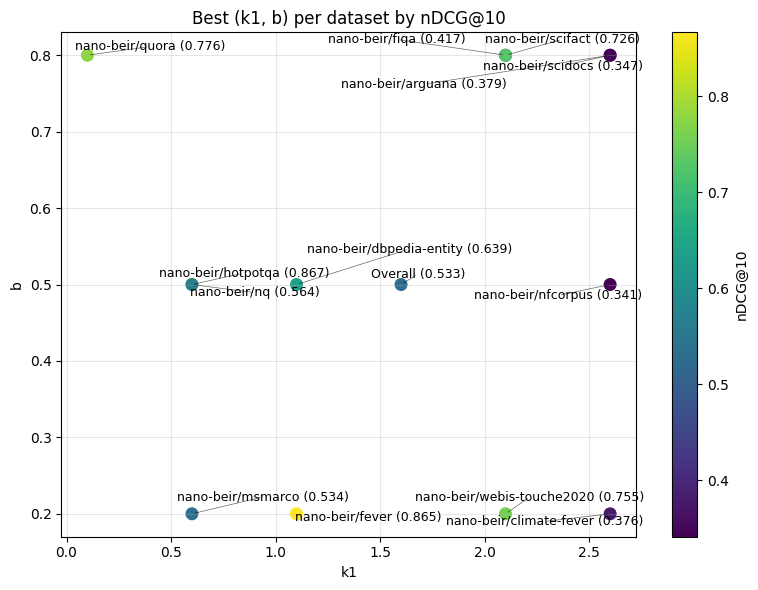

In [14]:
plot_optimal(results)

Now let's choose a few datasets which have highly variable document lengths to see how the parameter b affects nDCG.

In [26]:
SUBSET = [
    "nano-beir/arguana",
    "nano-beir/webis-touche2020",
    "nano-beir/scifact",
    "nano-beir/hotpotqa",
    "Overall",
]

filtered_results = results[results.dataset.astype(str).isin(SUBSET)]

In [27]:
filtered_results

,name,nDCG@10,dataset,k1,b
0,"BM25(k1=0.1, b=0.2)",0.244789,nano-beir/arguana,0.1,0.2
1,"BM25(k1=0.1, b=0.5)",0.256773,nano-beir/arguana,0.1,0.5
2,"BM25(k1=0.1, b=0.8)",0.263440,nano-beir/arguana,0.1,0.8
3,"BM25(k1=0.6, b=0.2)",0.276301,nano-beir/arguana,0.6,0.2
4,"BM25(k1=0.6, b=0.5)",0.295980,nano-beir/arguana,0.6,0.5
...,...,...,...,...,...
283,"BM25(k1=2.1, b=0.5)",0.532723,Overall,2.1,0.5
284,"BM25(k1=2.1, b=0.8)",0.529240,Overall,2.1,0.8
285,"BM25(k1=2.6, b=0.2)",0.518877,Overall,2.6,0.2
286,"BM25(k1=2.6, b=0.5)",0.530668,Overall,2.6,0.5


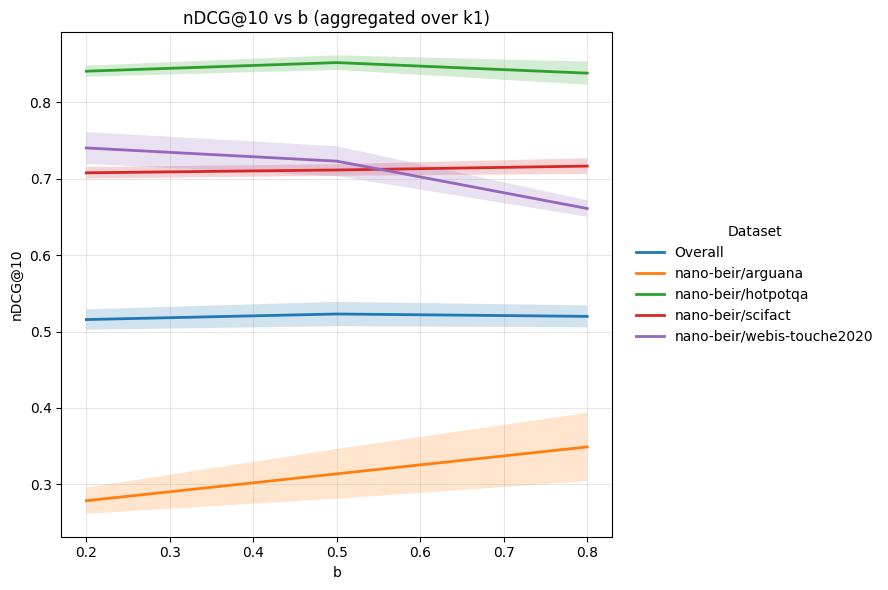

In [31]:
plot_metric_vs_b(filtered_results)